In [1]:
#聚类方法的实现

In [2]:
#导入包
import math
import random
import numpy as np
from sklearn import datasets,cluster
import matplotlib.pyplot as plt

In [3]:
iris =datasets.load_iris()
iris['target']
data=iris['data'][:,:2]

In [4]:
x=data[:,0]
y=data[:,1]

In [5]:
#可视化基本的数据

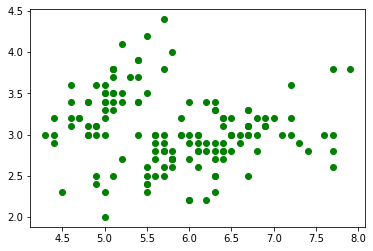

In [6]:
plt.scatter(x,y,color='green')


In [7]:
#先定义一个类，聚类节点

In [8]:
class ClusterNode:
    #中心vec，左节点left，右节点right，距离distance，标记id，叶子个数count
    def __init__(self,vec,left=None,right=None,distance=-1,id=None,count=1):
        self.vec=vec
        self.left=left
        self.right=right
        self.distance=distance
        self.id=id
        self.count=count
        

In [12]:
#定义一个距离函数，使用欧式距离
def euler_distance(point1: np.ndarray,point2: list)->float:
    distance=0.0
    for a,b in zip(point1,point2):
        distance+=math.pow(a-b,2)
    return math.sqrt(distance)

In [13]:
# 层次聚类（聚合法）

class Hierarchical:
    def __init__(self, k):
        self.k = k
        self.labels = None
        
    def fit(self, x):
        nodes = [ClusterNode(vec=v, id=i) for i, v in enumerate(x)]
        distances = {}
        point_num, feature_num = x.shape
        self.labels = [-1] * point_num
        currentclustid = -1
        while(len(nodes)) > self.k:
            min_dist = math.inf
            nodes_len = len(nodes)
            closest_part = None
            for i in range(nodes_len - 1):
                for j in range(i+1, nodes_len):
                    d_key = (nodes[i].id, nodes[j].id)
                    if d_key not in distances:
                        distances[d_key] = euler_distance(nodes[i].vec, nodes[j].vec)
                    d = distances[d_key]
                    if d < min_dist:
                        min_dist = d
                        closest_part = (i, j)
                        
            part1, part2 = closest_part
            node1, node2 = nodes[part1], nodes[part2]
            new_vec = [ (node1.vec[i] * node1.count + node2.vec[i] * node2.count ) / (node1.count + node2.count)
                        for i in range(feature_num)]
            new_node = ClusterNode(vec=new_vec,
                                   left=node1,
                                   right=node2,
                                   distance=min_dist,
                                   id=currentclustid,
                                   count=node1.count + node2.count)
            currentclustid -= 1
            del nodes[part2], nodes[part1]
            nodes.append(new_node)
            
        self.nodes = nodes
        self.calc_label()
        
    def calc_label(self):
        for i, node in enumerate(self.nodes):
            self.leaf_traversal(node, i)

    def leaf_traversal(self, node: ClusterNode, label):
        if node.left == None and node.right == None:
            self.labels[node.id] = label
        if node.left:
            self.leaf_traversal(node.left, label)
        if node.right:
            self.leaf_traversal(node.right, label)
            


In [14]:
my = Hierarchical(3)
my.fit(data)
labels=np.array(my.labels)
print(labels)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 2 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 1 0 0 1 2 1 0 1 0
 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


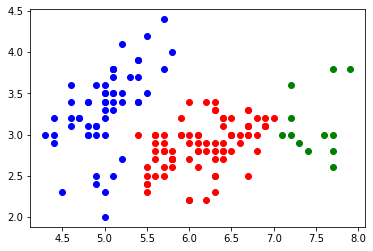

In [16]:
#可视化一下
#3类

cat1=data[np.where(labels==0)]
cat2=data[np.where(labels==1)]
cat3=data[np.where(labels==2)]

plt.scatter(cat1[:,0],cat1[:,1],color='red')
plt.scatter(cat2[:,0],cat2[:,1],color='green')
plt.scatter(cat3[:,0],cat3[:,1],color='blue')
plt.show()

In [18]:
#试着用sklearn数据集自带的来做
sk=cluster.AgglomerativeClustering(3)
sk.fit(data)
labels_=sk.labels_
print(labels_)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 2 0 2 0 1 0 1 1 0 2 0 2 0 2 2 2 2 0 0 2 0
 0 0 0 0 0 2 2 2 2 0 2 0 0 2 2 2 2 0 2 1 2 2 2 0 1 2 0 2 0 0 0 0 1 0 0 0 0
 0 0 2 2 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0
 0 0]


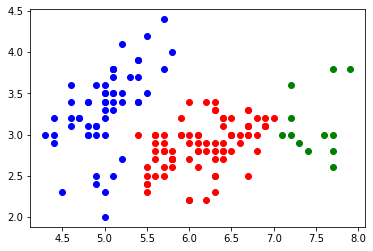

In [19]:
#将sk的结果可视化

cat1_=data[np.where(labels==0)]
cat2_=data[np.where(labels==1)]
cat3_=data[np.where(labels==2)]

plt.scatter(cat1_[:,0],cat1_[:,1],color='red')
plt.scatter(cat2_[:,0],cat2_[:,1],color='green')
plt.scatter(cat3_[:,0],cat3_[:,1],color='blue')

plt.show()

In [20]:
#结果一致，ok

In [21]:
#实现一下kmeans聚类方法

class mKmeans:
    def __init__(self,k,n=20):
        self.k=k
        self.n=n
    
    def fit(self,x,center=None):
        #随机选了k个点
        if center is None:
            id=np.random.randint(low=0,high=len(x),size=self.k)
            center=x[id]
            
        inter = 0
        while inter<self.n:
            points={key: [] for key in range(self.k)}
            
            #遍历点，将p放进相应的聚类
            for p in x:
                nearest_index=np.argmin(np.sum((center-p)**2,axis=1)**0.5)
                points[nearest_index].append(p)
            
            #计算新的聚类
            for i_k in range(self.k):
                center[i_k]=sum(points[i_k])/len(points[i_k])
                
            inter+=1
            
        return points, center
        
    

In [22]:
f = mKmeans(3)
points,center=f.fit(data)

In [23]:
center

array([[6.81276596, 3.07446809],
       [5.77358491, 2.69245283],
       [5.006     , 3.428     ]])

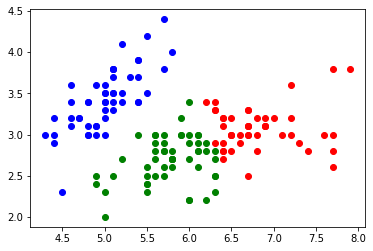

In [24]:
#可视化一下

cat1=np.asarray(points[0])
cat2=np.asarray(points[1])
cat3=np.asarray(points[2])

#加粗化forget

plt.scatter(cat1[:,0],cat1[:,1],color='red')
plt.scatter(cat2[:,0],cat2[:,1],color='green')
plt.scatter(cat3[:,0],cat3[:,1],color='blue')

plt.show()

In [27]:
#用sklearn中的kmeans来实现

kmeans=cluster.KMeans(n_clusters=3,max_iter=100).fit(data)
label=kmeans.labels_
centers=kmeans.cluster_centers_

In [28]:
label


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2,
       2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1])

In [29]:
centers

array([[5.006     , 3.428     ],
       [5.77358491, 2.69245283],
       [6.81276596, 3.07446809]])

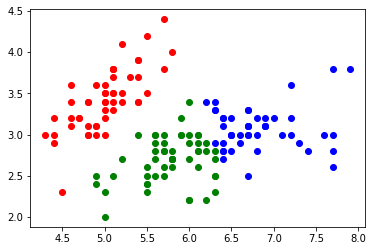

In [30]:
#可视化结果
cat1=data[label==0]
cat2=data[label==1]
cat3=data[label==2]

plt.scatter(cat1[:,0],cat1[:,1],color='red')
plt.scatter(cat2[:,0],cat2[:,1],color='green')
plt.scatter(cat3[:,0],cat3[:,1],color='blue')
plt.show()

In [31]:
#再探究一下 k值的选取


D:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


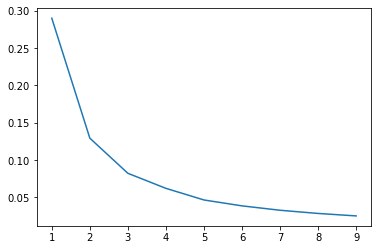

In [33]:
from sklearn.cluster import KMeans

loss=[]
for i in range(1,10):
    kmeans=KMeans(n_clusters=i,max_iter=100).fit(data)
    loss.append(kmeans.inertia_/len(data)/3)
    
plt.plot(range(1,10),loss)
plt.show()